In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


read csv from github

In [218]:
url = "https://raw.githubusercontent.com/philippdrebes/sda-hockey-c2d/main/data/dummy_data_complete.csv"
data = pd.read_csv(url, sep=",")
data = data.drop("Unnamed: 0", axis=1)

group dataframe by player id

In [219]:
avg_player = data.groupby(['Player ID', 'Position'], as_index=False).mean()
avg_player = avg_player.drop("Group Id", axis=1)


group dataframe by position

In [220]:
avg_position = data.groupby('Position', as_index=False).mean()
avg_position = avg_position.drop("Group Id", axis=1).drop("Player ID", axis=1)

create df with aggregated values (player values relative to average values of position)

In [221]:
rows = avg_player.shape[0]
values = []

for i in range(rows):
    dict_values = {}
    pos = avg_player.at[i,"Position"]
    dict_values["Player ID"] = avg_player.at[i,"Player ID"]
    for col in avg_player.columns:
        if col != "Player ID" and col != "Position":
            relative = avg_player.at[i, col] / avg_position.at[pos-1, col]
            dict_values[col] = relative
    values.append(dict_values)

agg_df = pd.DataFrame(values)     


    

evaluate agg_df and create two dfs (strengths and weaknesses) filtering only top and bottom 3 values per player

In [222]:
cols_for_evaluation = [col for col in agg_df.columns if col != "Player ID"]

# Perform the nlargest calculation on the other columns
strengths_df = (agg_df[cols_for_evaluation]
                  .stack()
                  .groupby(level=0)
                  .nlargest(3)
                  .unstack()
                  .reset_index(level=1, drop=True)
                  .reindex(columns=cols_for_evaluation))

# Reinsert the "Player ID" column into strengths_df
strengths_df.insert(0, 'Player ID', agg_df['Player ID'])

# Perform the nlargest calculation on the other columns
weaknesses_df = (agg_df[cols_for_evaluation]
                  .stack()
                  .groupby(level=0)
                  .nsmallest(3)
                  .unstack()
                  .reset_index(level=1, drop=True)
                  .reindex(columns=cols_for_evaluation))

# Reinsert the "Player ID" column into strengths_df
weaknesses_df.insert(0, 'Player ID', agg_df['Player ID'])

create dictionaries containing the weaknesses and strenghts for each player

In [223]:
rows = strengths_df.shape[0]

strengths_dict = {}
weaknesses_dict = {}

for i in range(rows):
    strengths_dict[strengths_df.at[i, "Player ID"]] = {}
    for col in strengths_df.columns:
        if col != "Player ID" and not np.isnan(strengths_df.loc[i, col]):
            strengths_dict[strengths_df.at[i, "Player ID"]][col] = strengths_df.at[i, col]

for i in range(rows):
    weaknesses_dict[weaknesses_df.at[i, "Player ID"]] = {}
    for col in weaknesses_df.columns:
        if col != "Player ID" and not np.isnan(weaknesses_df.loc[i, col]):
            weaknesses_dict[weaknesses_df.at[i, "Player ID"]][col] = weaknesses_df.at[i, col]
            

create function that retrieves strengths and weaknesses for one player from dictionaries, merges them in a dataframe and adds the reference values of the position group.

In [224]:
def prepare_for_visualization(player_id=63):
    #filter dictionaries based on input variable
    player_strengths = strengths_dict[player_id]
    player_weaknesses = weaknesses_dict[player_id]
    #create dataframes
    strength_df = pd.DataFrame([player_strengths])
    weaknesses_df = pd.DataFrame([player_weaknesses])
    #insert Player ID into dataframes and reorder columns to make sure Player ID is the first columns
    strength_df['Player ID'] = player_id
    weaknesses_df['Player ID'] = player_id
    strength_df = strength_df[['Player ID'] + [col for col in strength_df.columns if col != 'Player ID']]
    weaknesses_df = weaknesses_df[['Player ID'] + [col for col in weaknesses_df.columns if col != 'Player ID']]
    #merge strengths and weaknesses together
    player_df = pd.merge(strength_df, weaknesses_df, on="Player ID", how="inner")
    #lookup position of player
    position = avg_player.loc[avg_player['Player ID'] == player_id, 'Position'].values[0]
    #get values of best player
    condition = avg_player['Position'] == position 
    filtered_df = avg_player[condition]
    relevant_players = filtered_df["Player ID"].tolist()
    condition2= agg_df["Player ID"].isin(relevant_players)
    filtered_df2 = agg_df[condition2]
    row_sums = agg_df.iloc[:, 1:].sum(axis=1)
    max_row_index = row_sums.idxmax()
    player_id_with_highest_sum = agg_df.loc[max_row_index, 'Player ID']
    bestval1 = agg_df.loc[agg_df['Player ID'] == player_id_with_highest_sum, player_df.columns[1]].values[0]
    bestval2 = agg_df.loc[agg_df['Player ID'] == player_id_with_highest_sum, player_df.columns[2]].values[0]
    bestval3 = agg_df.loc[agg_df['Player ID'] == player_id_with_highest_sum, player_df.columns[3]].values[0]
    bestval4 = agg_df.loc[agg_df['Player ID'] == player_id_with_highest_sum, player_df.columns[4]].values[0]
    bestval5 = agg_df.loc[agg_df['Player ID'] == player_id_with_highest_sum, player_df.columns[5]].values[0]
    bestval6 = agg_df.loc[agg_df['Player ID'] == player_id_with_highest_sum, player_df.columns[6]].values[0]
    best_player_row = pd.Series(["Best Player",bestval1, bestval2, bestval3, bestval4, bestval5, bestval6], index=player_df.columns)
    player_df = player_df.append(best_player_row, ignore_index=True)
    #add row to dataframe with reference values (reference values are always 1)
    new_row = pd.Series(["avg. Position value",1,1,1,1,1,1], index=player_df.columns)
    player_df = player_df.append(new_row, ignore_index=True)
    
    return player_df

In [225]:
player_df = prepare_for_visualization()

C:\Users\linus.niederhauser\AppData\Local\Temp\ipykernel_8412\3057048774.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  player_df = player_df.append(best_player_row, ignore_index=True)
C:\Users\linus.niederhauser\AppData\Local\Temp\ipykernel_8412\3057048774.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  player_df = player_df.append(new_row, ignore_index=True)


define function for visualization

In [242]:
def visualization(df=player_df):

    BG_WHITE = "#fbf9f4"
    BLUE = "#2a475e"
    GREY70 = "#b3b3b3"
    GREY_LIGHT = "#f2efe8"
    COLORS = ["#FF5A5F", "#FFB400", "#007A87"]

    # define categories
    CATEGORIES = player_df["Player ID"].values.tolist()

    # define the six variables for the plot
    VARIABLES = player_df.columns.tolist()[1:]
    VARIABLES_N = len(VARIABLES)

    # define the angles at which the values of the numeric variables are placed
    ANGLES = [n / VARIABLES_N * 2 * np.pi for n in range(VARIABLES_N)]
    ANGLES += ANGLES[:1]

    # define padding used to customize the location of the tick labels
    X_VERTICAL_TICK_PADDING = 5
    X_HORIZONTAL_TICK_PADDING = 50    

    # define angle values going from 0 to 2*pi
    HANGLES = np.linspace(0, 2 * np.pi)

    # Used for the equivalent of horizontal lines in cartesian coordinates plots 
    # The last one is also used to add a fill which acts a background color.
    H0 = np.zeros(len(HANGLES))
    H1 = np.ones(len(HANGLES)) * 0.5
    H2 = np.ones(len(HANGLES))

    # Initialize layout ----------------------------------------------
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, polar=True)

    fig.patch.set_facecolor(BG_WHITE)
    ax.set_facecolor(BG_WHITE)

    # Rotate the "" 0 degrees on top. 
    # There it where the first variable, avg_bill_length, will go.
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Setting lower limit to negative value reduces overlap
    # for values that are 0 (the minimums)
    ax.set_ylim(0.8, 1.15)

    # Plot lines and dots --------------------------------------------
    for idx, species in enumerate(CATEGORIES):
        values = player_df.iloc[idx].drop("Player ID").values.tolist()
        values += values[:1]
        ax.plot(ANGLES, values, c=COLORS[idx], linewidth=4, label=species)
        ax.scatter(ANGLES, values, s=160, c=COLORS[idx], zorder=10)

    # Set values for the angular axis (x)
    ax.set_xticks(ANGLES[:-1])
    ax.set_xticklabels(VARIABLES, size=14)

    # Remove lines for radial axis (y)
    ax.set_yticks([])

    # Remove spines
    ax.spines["start"].set_color("none")

    # Add levels -----------------------------------------------------
    # These labels indicate the values of the radial axis
    PAD = 0.2
    ax.text(-0.7, 0 + PAD, "80%", size=12)
    ax.text(-0.4, 0.5 + PAD, "100%", size=12)
    ax.text(-0.7, 1 + PAD, "115%", size=12)

    #add legends
    handles = [
        Line2D(
            [], [], 
            c=color, 
            lw=3, 
            marker="o", 
            markersize=8, 
            label=species
        )
        for species, color in zip(CATEGORIES, COLORS)
    ]

    legend = ax.legend(
        handles=handles,
        loc=(1, 0),       # bottom-right
        labelspacing=1.5, # add space between labels
        frameon=False     # don't put a frame
    )

    # Iterate through text elements and change their properties
    for text in legend.get_texts():
        text.set_fontsize(16) 

    # Add title 
    fig.suptitle(
        "Radar Plot of Top 3 Player strengths and weaknesses compared to the average and the best player of his Position group",
        x = 0.1,
        y = 1,
        ha="left",
        fontsize=14,
        color=BLUE,
        weight="bold",    
    )

    fig.savefig('C:/Users/linus.niederhauser/OneDrive/2. Semester/SDS/radarplot.png', bbox_inches='tight')
    #plt.close(fig)



posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


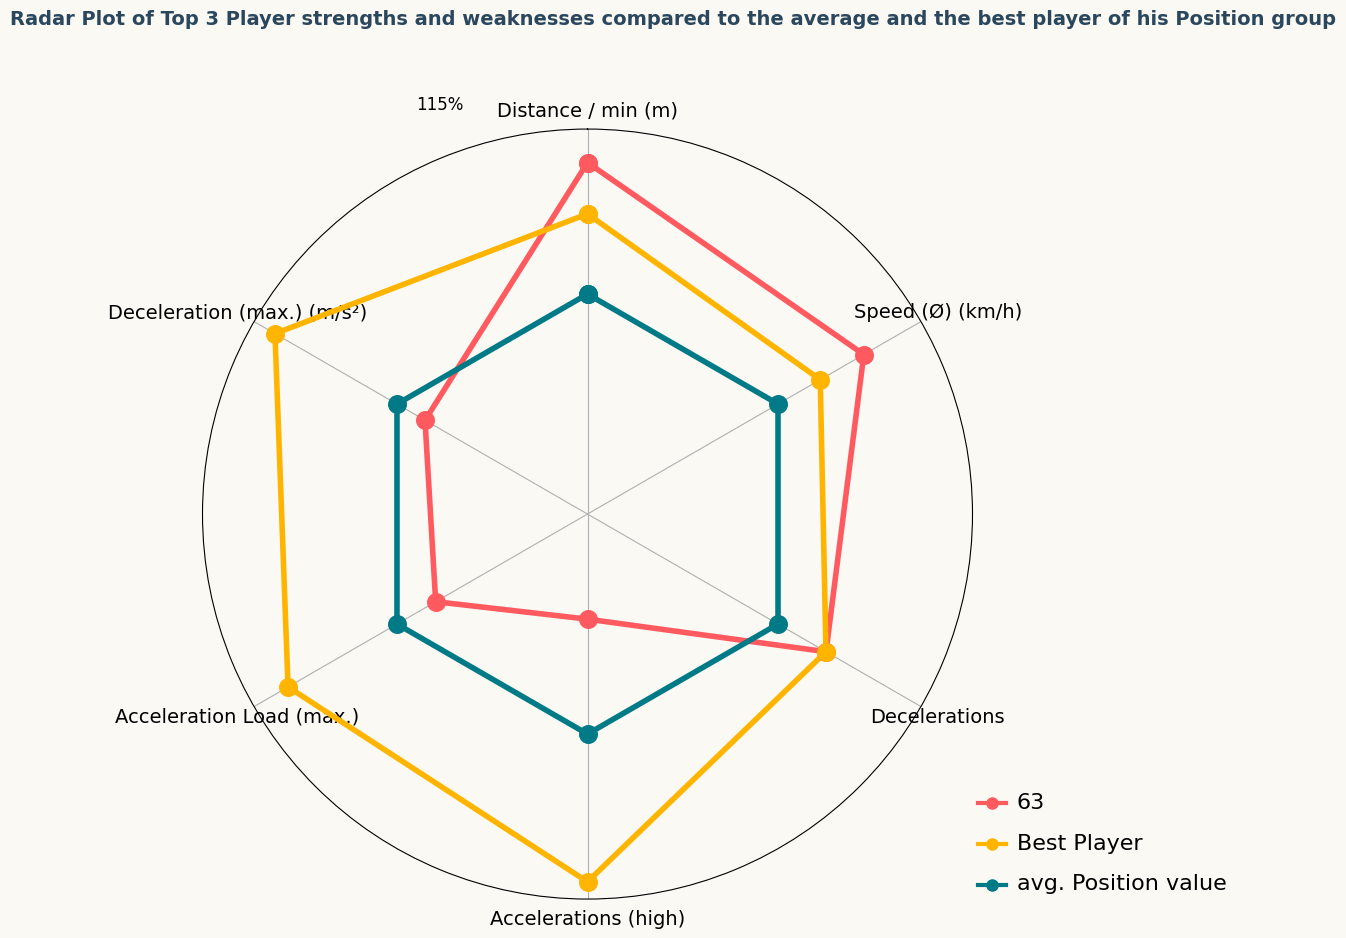

In [243]:
visualization()

create function for description

In [228]:
def description():
    #get player id of current player
    player_id = player_df.at[0, "Player ID"]
    #get strengths and weaknesses (text, values and relative values)
    strengths1_text = player_df.columns[1]
    strengths1_value = "{:.2f}".format(avg_player.loc[avg_player['Player ID'] == player_id, player_df.columns[1]].values[0])
    strenghts1_relative = "{:.2f}".format((player_df.loc[avg_player['Player ID'] == player_id, player_df.columns[1]].values[0]-1)*100)
    strengths2_text = player_df.columns[2]
    strengths2_value = "{:.2f}".format(avg_player.loc[avg_player['Player ID'] == player_id, player_df.columns[2]].values[0])
    strenghts2_relative = "{:.2f}".format((player_df.loc[avg_player['Player ID'] == player_id, player_df.columns[2]].values[0]-1)*100)
    strengths3_text = player_df.columns[3]
    strengths3_value = "{:.2f}".format(avg_player.loc[avg_player['Player ID'] == player_id, player_df.columns[3]].values[0])
    strenghts3_relative = "{:.2f}".format((player_df.loc[avg_player['Player ID'] == player_id, player_df.columns[3]].values[0]-1)*100)
    weakness1_text = player_df.columns[4]
    weakness1_value = "{:.2f}".format(avg_player.loc[avg_player['Player ID'] == player_id, player_df.columns[4]].values[0])
    weakness1_relative = "{:.2f}".format((1-player_df.loc[avg_player['Player ID'] == player_id, player_df.columns[4]].values[0])*100)
    weakness2_text = player_df.columns[5]
    weakness2_value = "{:.2f}".format(avg_player.loc[avg_player['Player ID'] == player_id, player_df.columns[5]].values[0])
    weakness2_relative = "{:.2f}".format((1-player_df.loc[avg_player['Player ID'] == player_id, player_df.columns[5]].values[0])*100)
    weakness3_text = player_df.columns[6]
    weakness3_value = "{:.2f}".format(avg_player.loc[avg_player['Player ID'] == player_id, player_df.columns[6]].values[0])
    weakness3_relative = "{:.2f}".format((1-player_df.loc[avg_player['Player ID'] == player_id, player_df.columns[6]].values[0])*100)
    #create string
    description = f"""
    Your three biggest strengths are:
    \t1. {strengths1_text} with an absolute value of {strengths1_value} which is {strenghts1_relative}% higher than the average of your Position group.
    \t2. {strengths2_text} with an absolute value of {strengths2_value} which is {strenghts2_relative}% higher than the average of your Position group.
    \t3. {strengths3_text} with an absolute value of {strengths3_value} which is {strenghts3_relative}% higher than the average of your Position group.\n
    Your three biggest weaknesses are:
    \t1. {weakness1_text} with an absolute value of {weakness1_value} which is {weakness1_relative}% lower than the average of your Position group.
    \t2. {weakness2_text} with an absolute value of {weakness2_value} which is {weakness2_relative}% lower than the average of your Position group.
    \t3. {weakness3_text} with an absolute value of {weakness3_value} which is {weakness3_relative}% lower than the average of your Position group.
    """
    # Specify the file path where you want to save the text document
    file_path = "C:/Users/linus.niederhauser/OneDrive/2. Semester/SDS/description.txt"
    # Open the file in write mode ('w')
    with open(file_path, 'w') as file:
        # Write the string data to the file
        file.write(description)

In [229]:
description()